#Desafio Cientista de Dados

Este projeto foi desenvolvido como parte de um desafio de cientista de dados para a empresa Indicium, contratado por um estúdio de Hollywood chamado Productions. O objetivo é realizar uma análise detalhada de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. A análise envolve a aplicação de técnicas de exploração de dados (EDA), modelagem preditiva e a recomendação de estratégias com base nos resultados obtidos.

###Leitura dos dados

Para começar o projeto iniciamos importando as bibliotecas necessárias, assim como realizar o carregamento do csv e leitura do mesmo.

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Carregar o arquivo CSV
file_path = 'desafio_indicium_imdb.csv'
data = pd.read_csv(file_path)

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [91]:
data.head(5)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [92]:
data.isnull().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Esse dataset é composto por 999 linhas e 16 colunas, sendo 12 do tipo objeto, 2 como int64 e 2 float64. Temos valores nulos nas colunas Gross, Meta_score e Certificate.

###Tratamento dos Dados

Vamos realizar o tratamento de algumas colunas, iniciando com a coluna "Gross" que é removido a vírgula e converter a coluna para float. Posteriormente convertemos a coluna "Runtime" para númerico e removemos a string min para poder focar nos valores númericos dessa coluna. Finalizando com as colunas "Meta_score" e "Released_Year" ambas são convertidas para númerico.

In [93]:
# Remover vírgulas e converter a coluna 'Gross' para float
data['Gross'] = data['Gross'].str.replace(',', '')
data['Gross'] = pd.to_numeric(data['Gross'], errors='coerce')

In [94]:
# Converter a coluna 'Runtime' para numérico, removendo ' min'
data['Runtime'] = data['Runtime'].str.replace(' min', '')
data['Runtime'] = pd.to_numeric(data['Runtime'], errors='coerce')

In [95]:
# Converter a coluna 'Meta_score' para numérico
data['Meta_score'] = pd.to_numeric(data['Meta_score'], errors='coerce')

In [96]:
# Converter a coluna 'Released_Year' para numérico
data['Released_Year'] = pd.to_numeric(data['Released_Year'], errors='coerce')

Posteriormente realizamos o tratamento de valores ausentes das colunas "Gross", "Meta_score", "Runtime", por serem valores númericos é calculada a média e incluído nos valores ausentes. Já a coluna "Certificate" não é possível aplicar o mesmo tratamento, dessa forma é removida as linhas com valores ausentes.

In [97]:
# Tratar valores ausentes
data['Gross'].fillna(data['Gross'].median(), inplace=True)
data['Meta_score'].fillna(data['Meta_score'].median(), inplace=True)
data['Runtime'].fillna(data['Runtime'].median(), inplace=True)

In [98]:
# Remover as linhas com valores ausentes
dados_tratados = data.dropna(subset=['Certificate'])

In [99]:
data.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,2,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,3,The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,4,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,5,The Lord of the Rings: The Return of the King,2003.0,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [100]:
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 898 entries, 0 to 996
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     898 non-null    int64  
 1   Series_Title   898 non-null    object 
 2   Released_Year  897 non-null    float64
 3   Certificate    898 non-null    object 
 4   Runtime        898 non-null    int64  
 5   Genre          898 non-null    object 
 6   IMDB_Rating    898 non-null    float64
 7   Overview       898 non-null    object 
 8   Meta_score     898 non-null    float64
 9   Director       898 non-null    object 
 10  Star1          898 non-null    object 
 11  Star2          898 non-null    object 
 12  Star3          898 non-null    object 
 13  Star4          898 non-null    object 
 14  No_of_Votes    898 non-null    int64  
 15  Gross          898 non-null    float64
dtypes: float64(4), int64(3), object(9)
memory usage: 119.3+ KB


Após realizarmos os tratamentos o dataset é ficou com 898 linhas e 16 colunas, sendo 9 do tipo objeto, 3 como int64 e 4 float64.

In [101]:
# Estatísticas descritivas
dados_tratados.describe()

,Unnamed: 0,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,898.000000,897.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02
mean,498.700445,1992.983278,124.187082,7.949777,77.737194,2.954914e+05,6.571775e+07
std,293.011318,21.836056,28.357618,0.278523,11.524197,3.298327e+05,1.056994e+08
min,1.000000,1921.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,239.250000,1980.000000,104.000000,7.700000,72.000000,6.415900e+04,5.573758e+06
50%,503.500000,1999.000000,120.000000,7.900000,79.000000,1.659370e+05,2.345744e+07
75%,756.750000,2010.000000,138.000000,8.100000,85.000000,4.194672e+05,7.498700e+07
max,997.000000,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


### Análise Exploratória dos Dados (EDA)

1.	Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses relacionadas. Seja criativo!

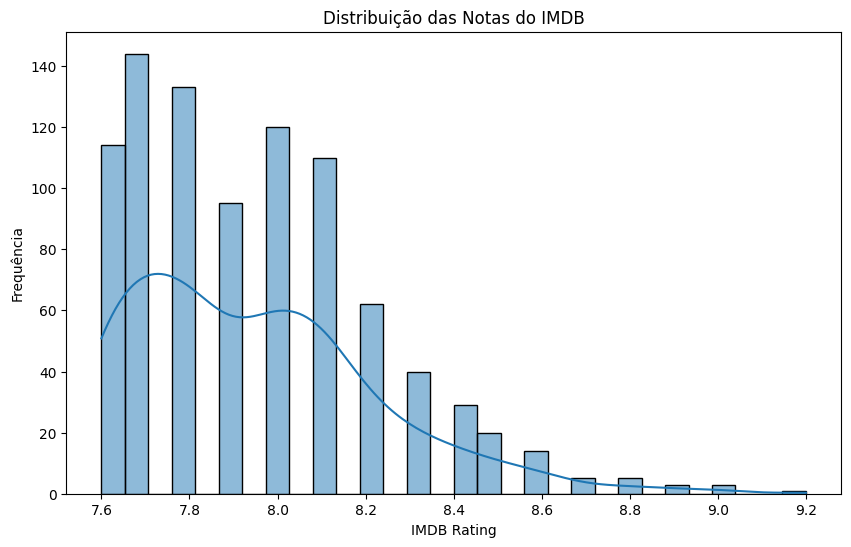

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(dados_tratados['IMDB_Rating'], kde=True, bins=30)
plt.title('Distribuição das Notas do IMDB')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequência')
plt.show()

Aqui podemos verificar que grande quantidade dos filmes avaliados ficaram com a pontuação na faixa de 7.6 até 8.1, mas tivemos alguns outliers que ficaram entre 9.0 e 9.2.

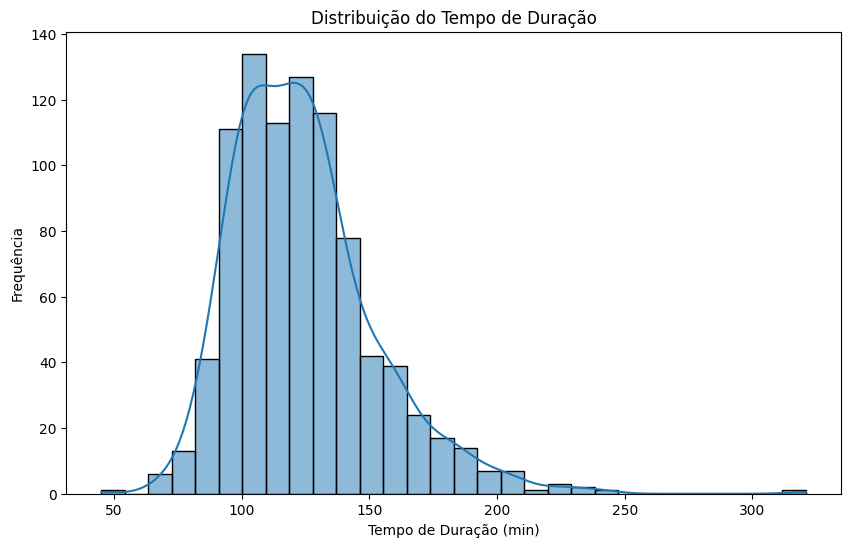

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(dados_tratados['Runtime'], kde=True, bins=30)
plt.title('Distribuição do Tempo de Duração')
plt.xlabel('Tempo de Duração (min)')
plt.ylabel('Frequência')
plt.show()


Aqui podemos verificar que grande quantidade dos filmes avaliados ficaram com a média de duração entre 90 a 140 minutos, mas tivemos alguns outliers que ficaram entre 50 e 300 minutos.

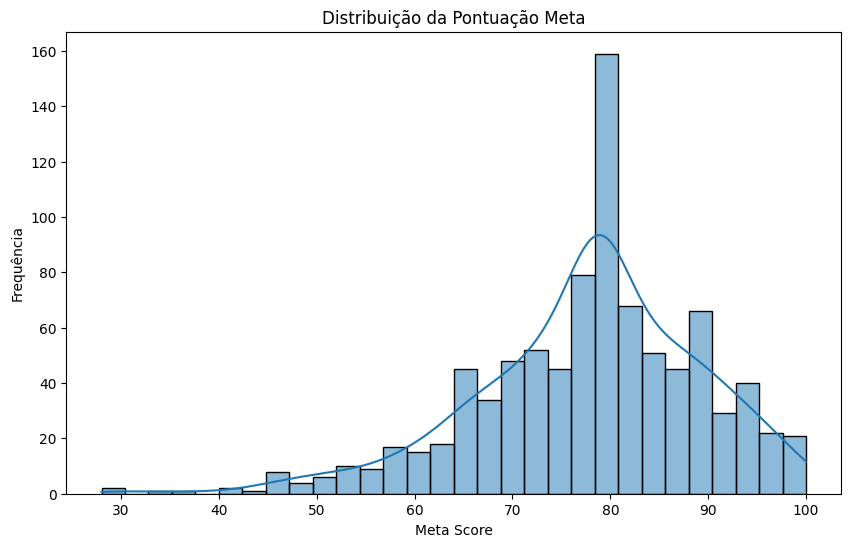

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(dados_tratados['Meta_score'], kde=True, bins=30)
plt.title('Distribuição da Pontuação Meta')
plt.xlabel('Meta Score')
plt.ylabel('Frequência')
plt.show()

Aqui podemos verificar que grande quantidade dos filmes avaliados ficaram com a média de pontuação na faixa de 80, mas tivemos alguns outliers que ficaram entre 30 e 100.

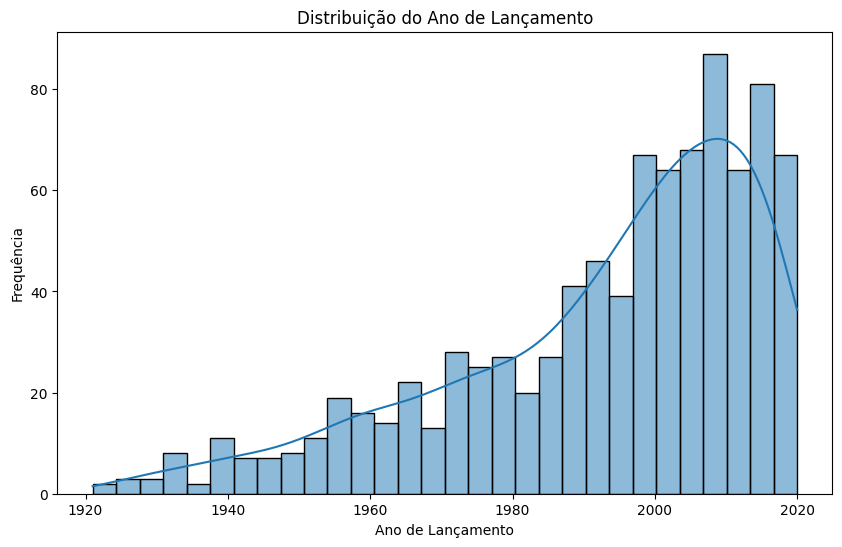

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(dados_tratados['Released_Year'], kde=True, bins=30)
plt.title('Distribuição do Ano de Lançamento')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Frequência')
plt.show()

<ipython-input-49-0b7dd0e596d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_tratados['Released_Year'] = pd.to_numeric(dados_tratados['Released_Year'], errors='coerce')
<ipython-input-49-0b7dd0e596d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Released_Year'] = data['Released_Year'].astype(int)
<ipython-input-49-0b7dd0e596d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

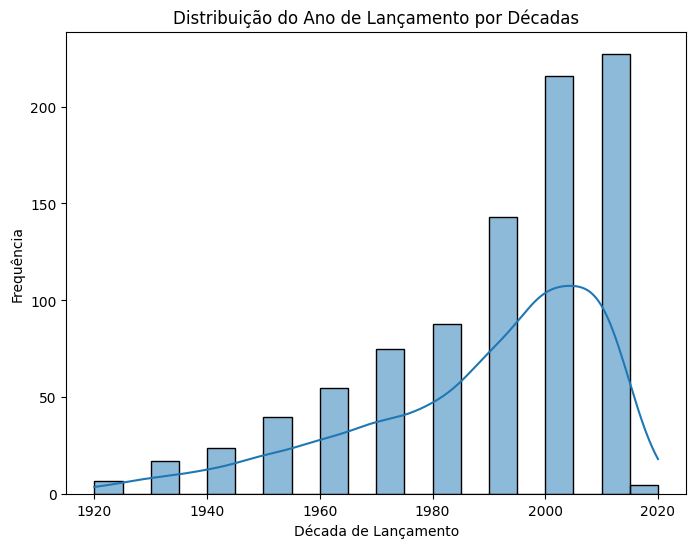

In [49]:
#Agrupando por décadas e removendo linhas com valores NaN resultantes da conversão
dados_tratados['Released_Year'] = pd.to_numeric(dados_tratados['Released_Year'], errors='coerce')
data = dados_tratados.dropna(subset=['Released_Year'])

# Converter a coluna para int após remover NaNs
data['Released_Year'] = data['Released_Year'].astype(int)

# Criar a coluna 'Decade'
data['Decade'] = (data['Released_Year'] // 10) * 10

plt.figure(figsize=(8, 6))
sns.histplot(data['Decade'], kde=True, bins=20)
plt.title('Distribuição do Ano de Lançamento por Décadas')
plt.xlabel('Década de Lançamento')
plt.ylabel('Frequência')
plt.show()

Aqui realizamos o agrupamento por década, onde podemos analisar que a cada década que passa a quantidade de lançamentos aumenta com exceção de 2020 onde pudemos ver uma grande queda, não temos maiores detalhes do porquê dessa queda, mas uma das hipóteses pode ter sido a pandemia que foi um impacto mundial.

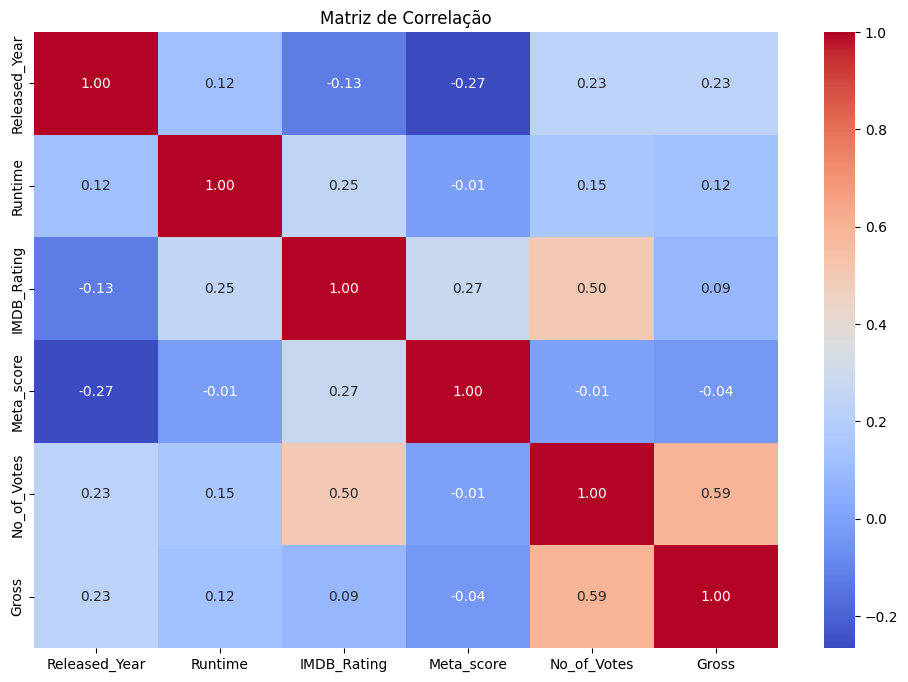

In [50]:
# Selecionar apenas colunas numéricas
numerical_data = dados_tratados.select_dtypes(include=['int64', 'float64'])

# Excluir coluna 'Unnamed'
numerical_data = numerical_data.loc[:, ~numerical_data.columns.str.startswith('Unnamed')]

# Calcular a matriz de correlação
correlation_matrix = numerical_data.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

Aqui realizamos a matriz de correlação em que se destacaram a correlação das seguintes colunas.

**Gross e No_of_Votes**:

Correlação: 0.59

Existe uma correlação positiva moderada entre a receita bruta (Gross) e o número de votos (No_of_Votes), sugerindo que filmes que geram mais receita tendem a receber mais votos.

**IMDB_Rating e No_of_Votes**:

Correlação: 0.50

Existe uma correlação positiva moderada entre a classificação do IMDB (IMDB_Rating) e o número de votos (No_of_Votes), indicando que filmes mais bem avaliados tendem a ter mais votos.

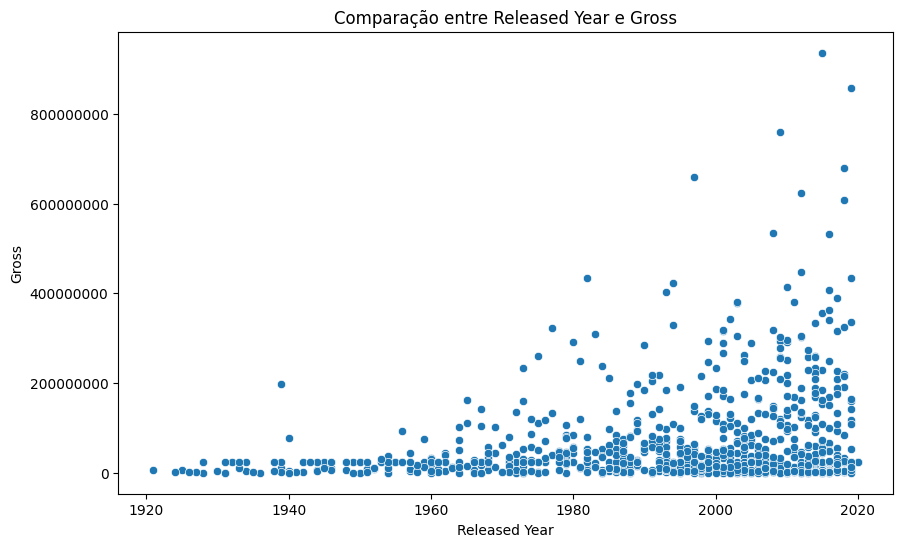

In [110]:
# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de dispersão
ax = sns.scatterplot(data=dados_tratados, x='Released_Year', y='Gross')

# Adicionar título e rótulos aos eixos
plt.title('Comparação entre Released Year e Gross')
plt.xlabel('Released Year')
plt.ylabel('Gross')

# Evitar notação científica no eixo y
ax.ticklabel_format(style='plain', axis='y')

# Mostrar o gráfico
plt.show()

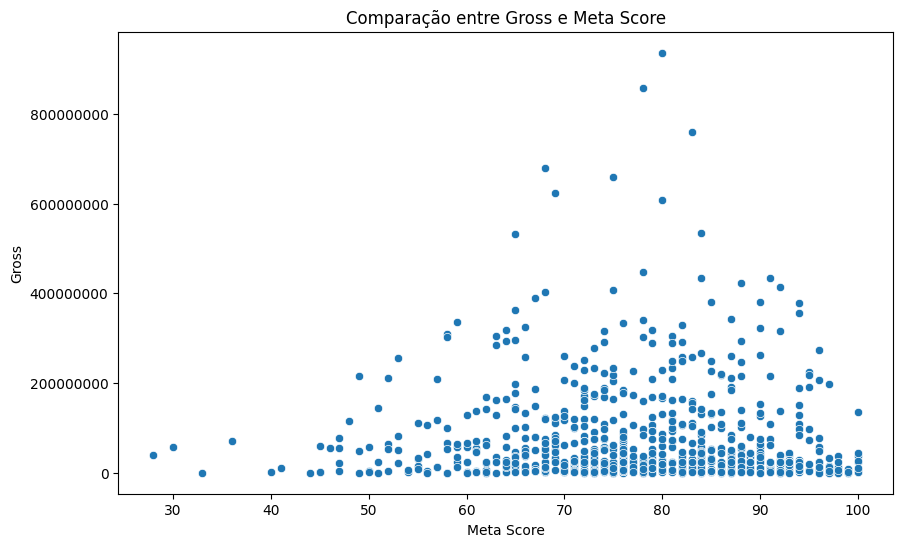

In [109]:
# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de dispersão
ax = sns.scatterplot(data=dados_tratados, x='Meta_score', y='Gross')

# Adicionar título e rótulos aos eixos
plt.title('Comparação entre Gross e Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('Gross')

# Evitar notação científica no eixo y
ax.ticklabel_format(style='plain', axis='y')

# Mostrar o gráfico
plt.show()

In [68]:
dados_tratados_v2 = dados_tratados.assign(Genre=dados_tratados['Genre'].str.replace(' ', ''))
dados_tratados_v2 = dados_tratados_v2.assign(Genre=dados_tratados_v2['Genre'].str.split(','))
dados_tratados_v2 = dados_tratados_v2.explode('Genre')

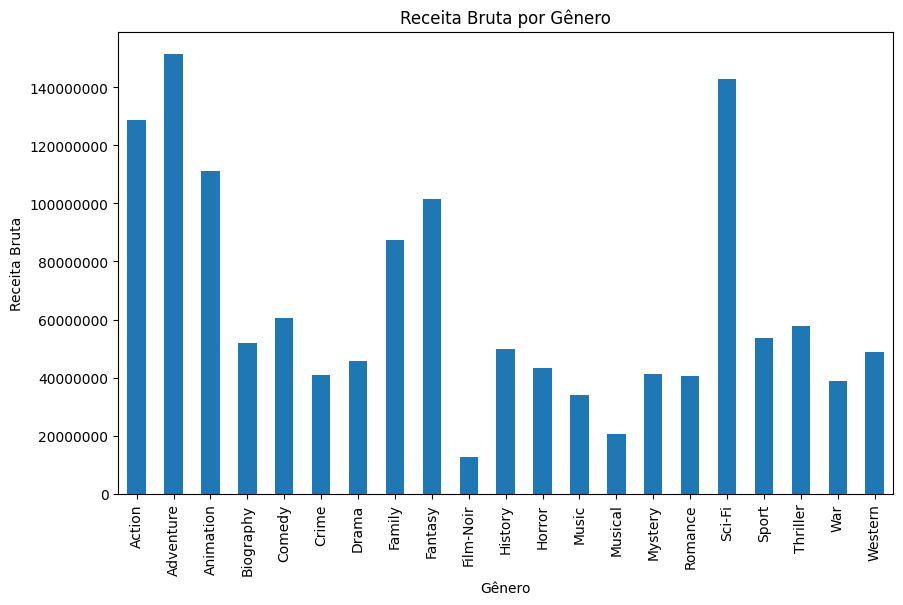

In [86]:
# Agrupar por gênero e calcular a média
genre_sum = dados_tratados_v2.groupby(['Genre']).mean(numeric_only=True)

plt.figure(figsize=(10, 6))
ax = genre_sum['Gross'].plot(kind='bar')
plt.title('Receita Bruta por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Receita Bruta')
plt.xticks(rotation=90)

ax.ticklabel_format(style='plain', axis='y')

plt.show()

Aqui realizamos o tratamento dos dados utilizando o método explode, que consiste em quebrar em mais linhas, cada valor passado na coluna gênero, posteriormente realizei o group by dos gêneros e fiz um comparativo da Receita Bruta de cada gênero.

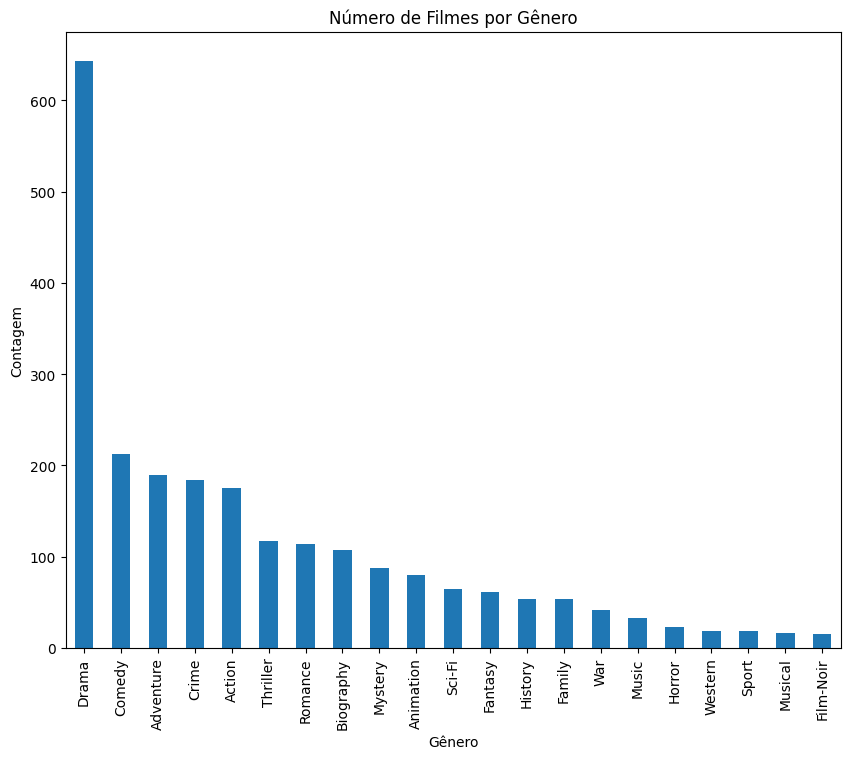

In [73]:
# Agrupar por gênero e contar o número de filmes por gênero
genre_counts = dados_tratados_v2['Genre'].value_counts()

plt.figure(figsize=(10, 8))
genre_counts.plot(kind='bar')
plt.title('Número de Filmes por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Agrupar por gênero e calcular a média
meta_sum = dados_tratados_v2.groupby(['Meta_score']).mean(numeric_only=True)

plt.figure(figsize=(10, 6))
ax = genre_sum['Gross'].plot(kind='bar')
plt.title('Receita Bruta por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Receita Bruta')
plt.xticks(rotation=90)

ax.ticklabel_format(style='plain', axis='y')

plt.show()

Após o tratamento realizado, realizamos a count da quantidade de filmes por gênero, que podemos perceber uma grande diferença do gênero Drama que é quase **3x maior** que o gênero de comédia que aparece em segundo.

Depois dessa análise, podemos concluir as seguintes hipóteses

**Hipótese 1**: Filmes com maior tempo de duração tendem a ter notas mais altas no IMDB, por serem filmes mais longos podem oferecer histórias mais desenvolvidas e, portanto, podem ser mais bem avaliados pelo público.

**Hipótese 2**:Certos gêneros, como ação e aventura, têm receitas brutas maiores comparadas a gêneros como drama ou comédia. Podemos sugerir que filmes de ação e aventura geralmente atraem públicos maiores e têm orçamentos maiores, o que pode levar a maiores receitas brutas.


2.
a) Qual filme você recomendaria para uma pessoa que você não conhece?

In [120]:
# Função para recomendar o filme com a maior avaliação no IMDB
def recomendar_filme(dados_tratados_v2):
    filme_recomendado = dados_tratados_v2.loc[dados_tratados_v2['IMDB_Rating'].idxmax()]
    return filme_recomendado['Series_Title']



In [122]:
# Recomendação de filme com base na maior avaliação no IMDB
filme_recomendado = recomendar_filme(dados_tratados_v2)
print(filme_recomendado)

0    The Godfather
0    The Godfather
Name: Series_Title, dtype: object


Para realizar a recomendação criamos uma função que pega na coluna "IMDB_Rating" pelo método idxmax, o filme que apresenta o maior valor.

b) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

In [124]:
# Função para identificar fatores relacionados com alta expectativa de faturamento
def fatores_alta_expectativa(dados_tratados_v2):
    # Definir um limiar para alto faturamento
    limiar_faturamento = dados_tratados_v2['Gross'].astype(str).replace(',', '', regex=True).astype(float).quantile(0.75)

    # Filtrar filmes com faturamento acima do limiar
    filmes_alta_expectativa = dados_tratados_v2[dados_tratados_v2['Gross'].astype(str).replace(',', '', regex=True).astype(float) > limiar_faturamento]

    # Analisar gêneros e atores principais
    generos_mais_comuns = filmes_alta_expectativa['Genre'].value_counts().head()
    atores_mais_comuns = pd.concat([filmes_alta_expectativa['Star1'], filmes_alta_expectativa['Star2'],
                                    filmes_alta_expectativa['Star3'], filmes_alta_expectativa['Star4']]).value_counts().head()

    return generos_mais_comuns, atores_mais_comuns

# Identificar fatores relacionados com alta expectativa de faturamento
generos_mais_comuns, atores_mais_comuns = fatores_alta_expectativa(dados_tratados_v2)
generos_mais_comuns, atores_mais_comuns

(Genre
 Drama        113
 Adventure     94
 Action        74
 Comedy        45
 Animation     32
 Name: count, dtype: int64,
 Tom Hanks            35
 Matt Damon           26
 Leonardo DiCaprio    23
 Harrison Ford        19
 Robert Downey Jr.    18
 Name: count, dtype: int64)

  Começamos criando a função para identificar fatores relacionados com alta expectativa de faturamento, posteriormente foi um limiar para alto faturamento, filtramos os filmes com faturamento acima do limiar, analisando os gêneros e atores principais.

  Podemos concluir que Drama, Aventura, Ação, Comédia e Animação são gêneros que tem um grande faturamento e atores como Tom Hanks, Matt Damon, Leonardo DiCaprio, Harrison Ford, Robert Downey Jr. conseguem arrecadar uma grande bilheteria.

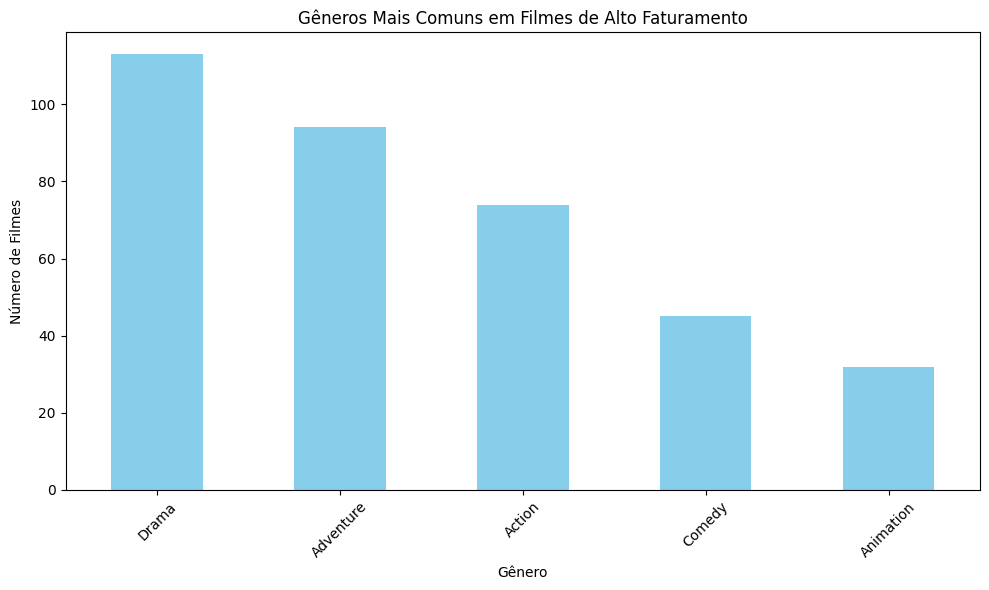

In [125]:
# Criando o gráfico de barras para os gêneros mais comuns
plt.figure(figsize=(10, 6))
generos_mais_comuns.plot(kind='bar', color='skyblue')
plt.title('Gêneros Mais Comuns em Filmes de Alto Faturamento')
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



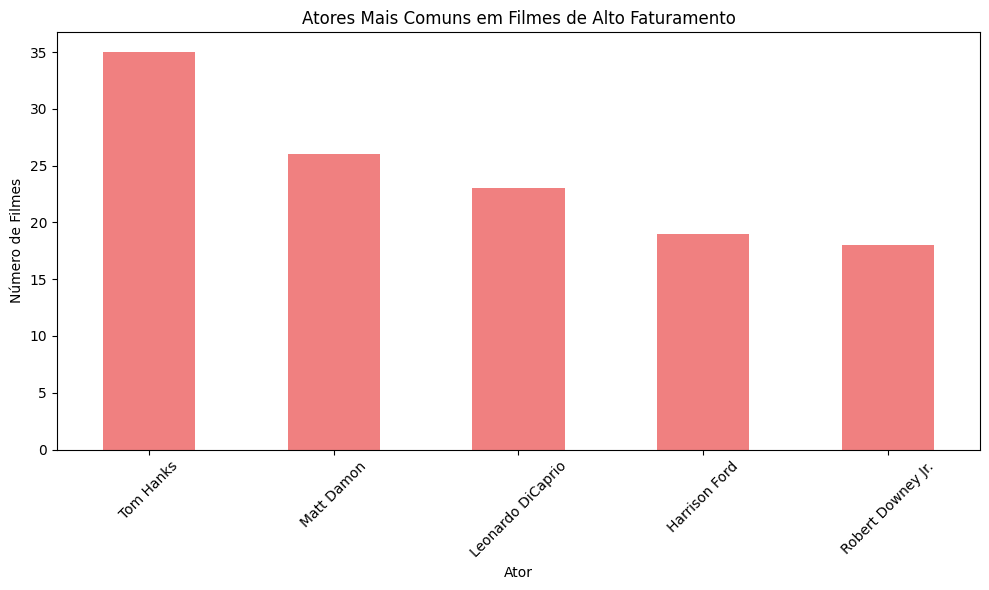

In [126]:
# Criando o gráfico de barras para os atores mais comuns
plt.figure(figsize=(10, 6))
atores_mais_comuns.plot(kind='bar', color='lightcoral')
plt.title('Atores Mais Comuns em Filmes de Alto Faturamento')
plt.xlabel('Ator')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

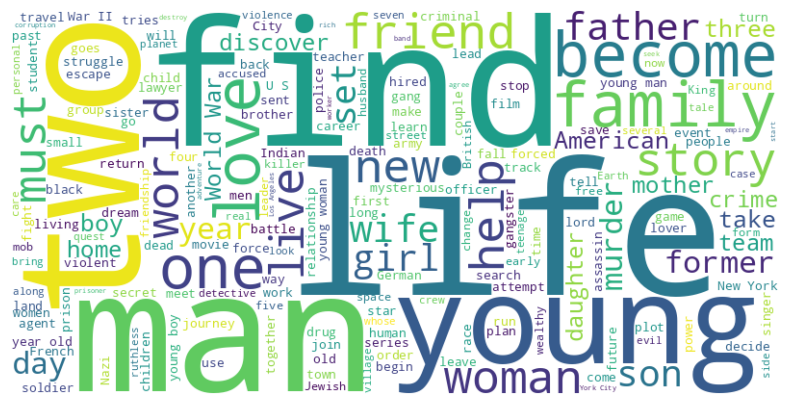

[('s', 239), ('young', 132), ('man', 119), ('after', 112), ('life', 111), ('two', 103), ('world', 85), ('they', 78), ('are', 75), ('new', 73), ('into', 72), ('up', 67), ('family', 66), ('war', 66), ('woman', 65), ('story', 63), ('him', 63), ('love', 61), ('one', 60), ('while', 57)]
Previsão de gênero para o resumo: ['Drama']


In [151]:
# Gerar uma word cloud a partir dos resumos (Overview)
text = " ".join(dados_tratados_v2['Overview'].dropna())

# Gerar a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Verificar as palavras mais comuns nos resumos
# Tokenizar o texto e remover palavras comuns (stop words)
words = re.findall(r'\w+', text.lower())
stop_words = set(['the', 'and', 'to', 'a', 'of', 'in', 'is', 'his', 'with', 'for', 'he', 'that', 'on', 'her', 'by', 'an', 'as', 'their', 'from', 'at', 'who', 'this', 'when', 'but', 'which'])

filtered_words = [word for word in words if word not in stop_words]

# Contar a frequência de cada palavra
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)

print(most_common_words)

# Criar uma string única a partir das palavras mais comuns
novo_resumo = " ".join(word for word, freq in most_common_words)

# Carregar os dados tratados novamente, se necessário
X = dados_tratados_v2['Overview'].dropna().reset_index(drop=True)
y = dados_tratados_v2['Genre'].iloc[X.index]

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar um pipeline de vetorização TF-IDF e classificação Naive Bayes
model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

# Treinar o modelo
model.fit(X_train, y_train)

# Exemplo de previsão para o novo resumo
predicao = model.predict([novo_resumo])
print(f'Previsão de gênero para o resumo: {predicao}')


3.	Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Para resolver o problema de previsão da nota do IMDb, podemos considerar vários modelos de aprendizado de máquina. A escolha do modelo depende de vários fatores, incluindo a natureza dos dados e a complexidade do relacionamento entre as variáveis. Aqui estão alguns modelos que poderiam ser considerados:

Regressão Linear: Um modelo simples que assume uma relação linear entre as variáveis independentes e a variável dependente (nota do IMDb). É fácil de interpretar e rápido para treinar, mas pode não capturar relações não lineares nos dados.

Árvores de Decisão e Random Forest: Modelos que capturam relações não lineares entre as variáveis. As árvores de decisão dividem os dados em segmentos menores com base nas variáveis, enquanto o Random Forest é uma combinação de várias árvores de decisão que reduz o overfitting. São modelos mais complexos que podem ser interpretados visualmente, mas podem ser propensos ao overfitting se não forem ajustados corretamente.

Gradient Boosting Machines (GBM) e XGBoost: Modelos avançados que melhoram a performance das árvores de decisão. Eles criam uma série de modelos fracos que melhoram iterativamente, ajustando-se aos erros residuais do modelo anterior. São muito poderosos e podem lidar bem com grandes volumes de dados e muitas features, mas são mais complexos e exigem mais tempo de treinamento.

Redes Neurais: Modelos que podem capturar relações complexas entre as variáveis através de camadas de neurônios interconectados. São particularmente eficazes em dados não estruturados, como imagens e texto, mas exigem grandes quantidades de dados para treinar adequadamente e são menos interpretáveis do que os modelos baseados em árvores.

Avaliação de Performance do Modelo

A avaliação de performance é crucial para determinar quão bem o modelo está prever a nota do IMDb. Aqui estão algumas métricas comuns usadas para avaliar modelos de regressão:

Erro Quadrático Médio (Mean Squared Error - MSE): Calcula a média dos quadrados dos erros entre as previsões e os valores reais. Penaliza mais os erros maiores, o que pode ser útil se desejamos evitar grandes desvios nas previsões.

Erro Absoluto Médio (Mean Absolute Error - MAE): Calcula a média dos valores absolutos dos erros entre as previsões e os valores reais. É menos sensível a outliers do que o MSE e fornece uma medida mais intuitiva da média dos erros.

R² (Coeficiente de Determinação): Indica a proporção da variabilidade da variável dependente que é explicada pelo modelo. Varia entre 0 e 1, onde 1 indica um ajuste perfeito.



```
# Limpar os dados removendo linhas com valores nulos nas colunas relevantes
df_cleaned = data.dropna(subset=['IMDB_Rating', 'Released_Year', 'Runtime', 'Genre', 'Meta_score', 'No_of_Votes'])

# Converter a coluna Runtime para formato numérico (minutos)
df_cleaned['Runtime'] = df_cleaned['Runtime'].str.replace(' min', '').astype(int)

# Selecionar colunas categóricas
categorical_cols = ['Genre', 'Certificate','Director']

# Aplicar OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df_cleaned[categorical_cols])

# Concatenar features numéricas e categóricas
X_numerical = df_cleaned[['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes']].values
X_final = np.hstack((X_numerical, X_encoded))

# Separar features e target
y = df_cleaned['IMDB_Rating']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Treinar modelo de regressão linear
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Prever notas no conjunto de teste
y_pred_lr = model_lr.predict(X_test)

# Avaliar modelo usando RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'Regressão Linear - RMSE: {rmse_lr}')
```





```
from sklearn.ensemble import RandomForestRegressor

# Treinar modelo Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Prever notas no conjunto de teste
y_pred_rf = model_rf.predict(X_test)

# Avaliar modelo usando RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest - RMSE: {rmse_rf}')
```





```
import xgboost as xgb

# Converter dados para formato compatível com XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir parâmetros do modelo
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Treinar modelo XGBoost
num_rounds = 100
model_xgb = xgb.train(params, dtrain, num_rounds)

# Prever notas no conjunto de teste
y_pred_xgb = model_xgb.predict(dtest)

# Avaliar modelo usando RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost - RMSE: {rmse_xgb}')

```



Através desses códigos obtive os respectivos valores:

XGBoost - RMSE: 0.1975567483504392

Random Forest - RMSE: 0.18983194062241818

Regressão Linear - RMSE: 0.291312340871687

Seguindo o padrão de RMSE, o mais indicado nesse caso é Random Forest.

4.	Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',

>  'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'





Qual seria a nota do IMDB?


In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Definição dos dados do filme
filme = {
   'Series_Title': 'The Shawshank Redemption',
   'Released_Year': 1994,
   'Certificate': 'A',
   'Runtime': 142,
   'Genre': 'Drama',
   'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
   'Meta_score': 80.0,
   'Director': 'Frank Darabont',
   'Star1': 'Tim Robbins',
   'Star2': 'Morgan Freeman',
   'Star3': 'Bob Gunton',
   'Star4': 'William Sadler',
   'No_of_Votes': 2343110,
   'Gross': 28341469,
}
# Transformar em DataFrame
df = pd.DataFrame([filme])

# Selecionar características relevantes
features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']

# Dividir dados em conjunto de treino e teste
X_train = df[features]

# Treinar modelo de regressão XGBoost
model = XGBRegressor()
model.fit(X_train, y_train)

# Fazer previsão
y_pred = model.predict(X_train)

# Mostrar valor previsto
print(f'Valor previsto do IMDb Rating: {y_pred[0]:.2f}')



Valor previsto do IMDb Rating: 9.30


['imdb_rating_predictor.pkl']

5.	Salve o modelo desenvolvido no formato .pkl.

In [183]:
import joblib
joblib.dump(model, 'imdb_rating_predictor.pkl')

['imdb_rating_predictor.pkl']